In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

In [2]:
# Let's have some simple data.
data= np.random.rand(50,100)

# Simple analysis - calculates the sum in each row of the data.
def analyze(data):
    sums=np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        sum= 0
        for j in range(data.shape[1]):
            sum= sum + data[i,j]
        sums[i]=sum
    return sums

In [3]:
# Here are the numbers from the analysis of the single input data.
analyze(data)

array([51.86138781, 50.75904264, 49.83986989, 51.2493541 , 58.2292473 ,
       52.97499021, 45.88200753, 53.53350543, 46.26434112, 48.22021812,
       50.35130006, 54.34179079, 52.58484409, 48.95205835, 47.99211251,
       48.03792884, 50.14916415, 53.18206636, 50.383184  , 50.05034425,
       52.27233315, 49.83946342, 49.12430896, 53.69540435, 53.18349686,
       46.55540971, 50.61652752, 47.30670865, 51.17118165, 50.67041556,
       50.99347632, 49.98911115, 47.97725276, 51.07063625, 53.35134064,
       50.3559079 , 49.99827301, 52.10798563, 54.01078061, 50.55872108,
       48.17523372, 49.27325598, 50.35421004, 49.28342678, 49.53911729,
       47.00684658, 46.38015662, 50.4570056 , 46.29976009, 51.39829303])

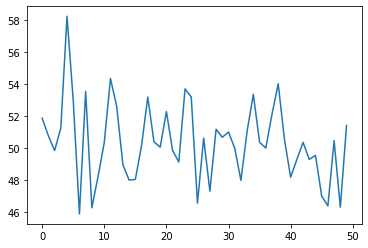

In [4]:
# Let's visualize the raw results.
plt.plot(analyze(data));

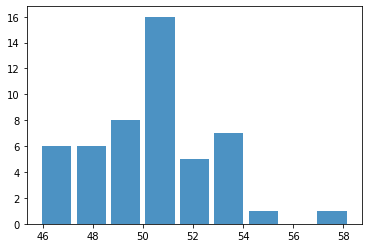

In [5]:
# Here is a histogram/distribution of the sums for each row. 
plt.hist(analyze(data), bins='auto', alpha=0.8 ,rwidth=0.85);

Again, for simplicity, let's create 5 (random) data inputs, run the analysis on each input, and calculate the average distribution for the sums on each row for all set of data. We will artificially slow down the analysis with 1s `sleep(1)` to mimick more computationaly demanding analysis than will benefit from parallel execution.

In [6]:
n= 50; m=100;           # Shape of the data input
frames= 5;              # Number of data inputs to generate

histograms= np.zeros(n) # Accumulate the partial results

# Simple analysis
def analyze(data):
    sums= np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        sum= 0
        for j in range(data.shape[1]):
            sum= sum + data[i,j]
        sums[i]= sum
    sleep(1);         # Let's slow it down artificially    
    return sums

# Generate random data, analyze, and collect
for i in range(frames):
    histograms= histograms + analyze(np.random.rand(n,m))

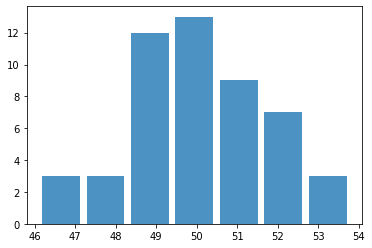

In [7]:
plt.hist(histograms/frames, bins='auto', alpha=0.8 ,rwidth=0.85);

## Need for speed

Time to split the work and analyze it in parallel/simultaneously - should be easy since each analysis is an independent calculation. 

### `multiprocessing` - Process-based parallelism [online documentation](https://docs.python.org/3/library/multiprocessing.html)

Here we will need two additional classes:
- [Process](https://docs.python.org/3/library/multiprocessing.html#the-process-class)
- [JoinableQueue](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.JoinableQueue)

The `Process` class will allow us to define, keep track, and start separate processes
```python
for w in range(N_workers):
    p= Process(name="workers", target=analyze, args=(todo, done));
    processes.append(p);
    p.start();
```

and `JoinableQueue` has a bit more features than `Queue` class and will allow us to
- define and add tasks to a queue `todo` (serial)
- get task from the `todo` queue and perform the calculation, then put results in another queue `done` and signal that the task is done (in parallel)

Collecting the partial results from the `done` queue is done at the end (serial) when all `todo` task are done.

**The datails of the code below will be discussed in details during the workshop.**

# Debug 1
## Debug:130640 analyze done
## Debug:130641 analyze done
## Debug:130642 analyze done
## Debug:130644 analyze done
## Debug:130643 analyze done





## Debug:130641 analyze done
## Debug:130640 analyze done


# Debug 2
# Debug 3
# Debug 4


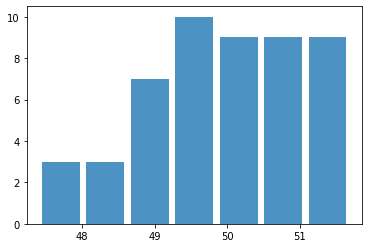

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from multiprocessing import Process, JoinableQueue
import os

n= 50; m=100;            # Shape of the data input
frames= 7;               # Number of data inputs to generate
N_workers= 5;            # Numbers of instances to work on the analysis

histograms= np.zeros(n); # Accumulate the partial results

# Simple analysis
def analyze(todo, done):
    while True:
        data= todo.get();
        sums= np.zeros(data.shape[0]);
        for i in range(data.shape[0]):
            sum= 0;
            for j in range(data.shape[1]):
                sum= sum + data[i,j];
            sums[i]= sum;
        sleep(1);         # Let's slow it down artificially
        print('## Debug:' + str(os.getpid()) + ' analyze done\n',flush=True);
        done.put(sums);   # Instead of returning - pt the result in the done queue
        todo.task_done(); # Signal that the task is done

    
# Define two queues todo and done
todo = JoinableQueue();
done = JoinableQueue();
processes = [];          # List to keep track of created processes, to be terminated at the end

# Define and start processes =================================
for w in range(N_workers):
    p= Process(name="p"+str(w), target=analyze, args=(todo, done));
    processes.append(p); # Append to the process tracking list
    p.start();           # Start the defined process
    
    
# Generate random data, analyze, and collect
for i in range(frames):
    #histograms= histograms + analyze(np.random.rand(n,m))
    todo.put(np.random.rand(n,m));
todo.close()
    
print('# Debug 1');
# Wait for the workers to finish the todo queue ==============
todo.join();

print('# Debug 2');
# kill the processes
for p in processes:
    p.kill()
    
print('# Debug 3');
for i in range(done.qsize()):
    histograms= histograms + done.get();
    
    
print('# Debug 4');
# Plot the result
plt.hist(histograms/frames, bins='auto', alpha=0.8 ,rwidth=0.85);